## Dependencies

In [775]:
import networkx as nx
import matplotlib.pyplot as plt
import ast
import os
import textwrap
from tabulate import tabulate
from termcolor import colored
import re
import gc

## Classes Definitions

In [776]:
class DDG_Node:
    def __init__(self, line_number,statement):
        self.statement = statement
        self.line_number = line_number
        self.has=[]
        self.needs=[]

In [777]:
class DDG_Edge:
    def __init__(self, src, dest,dependencies):
        self.src = src
        self.dest = dest
        self.dependencies = dependencies

In [778]:
class Debugger:
    def __init__(self):
        pass
    def print_unparsed_function(self, function):
        print("\n" + "="*40)
        print(f"Function Extracted: {function.name}")
        print("="*40)
        print(textwrap.indent(ast.unparse(function), "    "))  # Indent for readability
        print("="*40)
        print(f"Function Completed: {function.name}")
        print("="*40)
    def print_entry_point(self, entry_point):
        print("\n" + "="*40)
        print(f"Entry Point Extracted")
        print("="*40)
        print(textwrap.indent(entry_point, "    "))
        print("="*40)
        print(f"Entry Point Completed")
        print("="*40)
    def print_DDG_node(self, node):
        print("\n" + "="*40)
        print(f"Line Number: {node.line_number}")
        print("\n" + "="*40)
        print(f"Has: {node.has}")
        print("\n" + "="*40)
        print(f"Needs: {node.needs}")
        print("\n" + "="*40)
    def print_DDG_edge(self, edge):
        print("\n" + "="*40)
        print("\n")
        print(f"Source: {edge.src}")
        print(f"Destination: {edge.dest}")
        print(f"Dependencies: {edge.dependencies}")
        print("\n" + "="*40)


In [779]:
class DDG:
    def __init__(self,tree):
        self.tree = tree
        self.functions = []
        self.entry_point = None
        self.debugger=Debugger()
        self.edges=[]
        self.nodes=[]    
    #! extract functiona and entry point
    def extract_snippets(self,debug=False):
       for node in self.tree.body:
        #! Get function source code, name and arguements and put them in a tuple
        if isinstance(node, ast.FunctionDef):
            func_name = node.name
            arguements = [arg.arg for arg in node.args.args]
            func_code = ast.unparse(node)  
            pattern = rf'def\s+{func_name}\s*\(.*?\):\s*\n'
            func_code = re.sub(pattern, '', func_code)
            func_code = textwrap.dedent(func_code)
            self.functions.append((func_name,arguements,func_code))
            if debug:
                self.debugger.print_unparsed_function(node)
        elif isinstance(node, ast.If):
            self.entry_point = ast.unparse(node)
            self.entry_point = self.entry_point.replace("if __name__ == '__main__':", "")
            self.entry_point=textwrap.dedent(self.entry_point)
            if debug:
                self.debugger.print_entry_point(self.entry_point)
    
    #? TODO Handle Loops
    def extract_dependencies(self,snippet,function=False,debug=False):
        if not self.functions and not self.entry_point:
            raise ValueError("No functions or entry points to extract dependencies from. Please run 'extract_snippets' first.")
        #! habdle the function tuple
        if function:
            func_name=self.functions[0][0]
            arguements=self.functions[0][1]
            snippet=self.functions[0][2]
            #! add the function definition as a node
            node = DDG_Node(0,'def '+func_name+'('+','.join(arguements)+'):')
            node.has.extend(arguements)
            self.nodes.append(node)
            
        sub_tree=ast.parse(snippet)
        def visit_has_needs(self, node,number):
            #! create a new node
            gnode = DDG_Node(number,ast.unparse(node))
            #! get variables being assigned to
            if isinstance(node, ast.Assign):  
                for target in node.targets:
                    if isinstance(target, ast.Name):
                        gnode.has.append(target.id)
            #! handle if conditions
            if isinstance(node, ast.If):
                temp = set()
                for subnode in ast.walk(node):
                    if isinstance(subnode, ast.Assign):
                        for target in subnode.targets:
                            if isinstance(target, ast.Name):
                                temp.add(target.id)
                gnode.has.extend(temp)
                del temp
                gc.collect()
            #! handle the function return statement
            elif isinstance(node, ast.Return):
                if isinstance(node.value, ast.Name):
                    gnode.needs.append(node.value.id)
            #! Get variables used in the assignment
            used_vars = {name.id for name in ast.walk(node) if isinstance(name, ast.Name) and isinstance(name.ctx, ast.Load)}
            gnode.needs.extend(used_vars)
            self.nodes.append(gnode)
            if debug:
                self.debugger.print_DDG_node(gnode)
        for i,node in enumerate(sub_tree.body):
            visit_has_needs(self,node,i+1)
            
    def construct_edges(self,debug=False):
        if not self.nodes:
            raise ValueError("No nodes to construct edges from. Please run 'extract_dependencies' first.")
        #! a dictionary to hold the last occurence OF dependencies
        deps={}
        for node in self.nodes:
            edges_to_construct={}
            for need in node.needs:
                if need in deps:
                    if (deps[need],node.line_number) not in edges_to_construct:
                        edges_to_construct[(deps[need],node.line_number)]=[]
                    edges_to_construct[(deps[need],node.line_number)].append(need)
            for edge in edges_to_construct:
                edge=DDG_Edge(edge[0],edge[1],edges_to_construct[edge])
                self.edges.append(edge)    
                if debug:
                    self.debugger.print_DDG_edge(edge)
            for has in node.has:
                deps[has]=node.line_number
    def visualize_graph(self):
        if not self.nodes or not self.edges:
            raise ValueError("No nodes or edges to visualize. Please run 'extract_dependencies' and 'construct_edges' first.")
        G = nx.DiGraph()
        for node in self.nodes:
            G.add_node(node.line_number)

        edge_labels = {}
        for edge in self.edges:
            G.add_edge(edge.src, edge.dest)
            edge_labels[(edge.src, edge.dest)] = ", ".join(map(str, edge.dependencies)) 

        pos = nx.spring_layout(G, k=5)  #! Adjust k to control spacing

        nx.draw(
            G, pos, with_labels=True, 
            node_size=2000, node_color='darkblue', 
            font_color='white', font_weight='bold', font_size=12
        )

        nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
        plt.show()
  

    def visualize_graph_data(self):
        if not self.nodes or not self.edges:
            raise ValueError("No nodes or edges to visualize. Please run 'extract_dependencies' and 'construct_edges' first.")
        node_data = [{'code line': node.line_number,'statement':node.statement, 'has': node.has, 'needs': node.needs} for node in self.nodes]
        edge_data = [{'Node': edge.dest, 'Depends on': edge.src,  'Dependency': edge.dependencies} for edge in self.edges]

        node_table = tabulate(node_data, headers="keys", tablefmt="fancy_grid")
        edge_table = tabulate(edge_data, headers="keys", tablefmt="fancy_grid")

        print(colored("Nodes Table:", "cyan", attrs=["bold"]))
        print(node_table)
        print("\n" + colored("Edges Table:", "yellow", attrs=["bold"]))
        print(edge_table)


        

## GLobal Variables for testing

In [780]:
testcases_folder_path="testcases"
testcase=os.path.join(testcases_folder_path, "t2_basic_function_parsing.py")

## Implementation Testing

In [781]:
tree = ast.parse(open(testcase).read())

In [782]:
print(ast.dump(tree, indent=4))

Module(
    body=[
        FunctionDef(
            name='func1',
            args=arguments(
                posonlyargs=[],
                args=[
                    arg(arg='x')],
                kwonlyargs=[],
                kw_defaults=[],
                defaults=[]),
            body=[
                Assign(
                    targets=[
                        Name(id='x', ctx=Store())],
                    value=BinOp(
                        left=Name(id='x', ctx=Load()),
                        op=Add(),
                        right=Constant(value=2))),
                Assign(
                    targets=[
                        Name(id='y', ctx=Store())],
                    value=Name(id='x', ctx=Load())),
                Assign(
                    targets=[
                        Name(id='z', ctx=Store())],
                    value=BinOp(
                        left=BinOp(
                            left=Name(id='x', ctx=Load()),
                            op=M

In [783]:
graph=DDG(tree)
graph.extract_snippets()

In [784]:
graph.extract_dependencies(graph.functions[0],function=True)

In [785]:
graph.construct_edges()

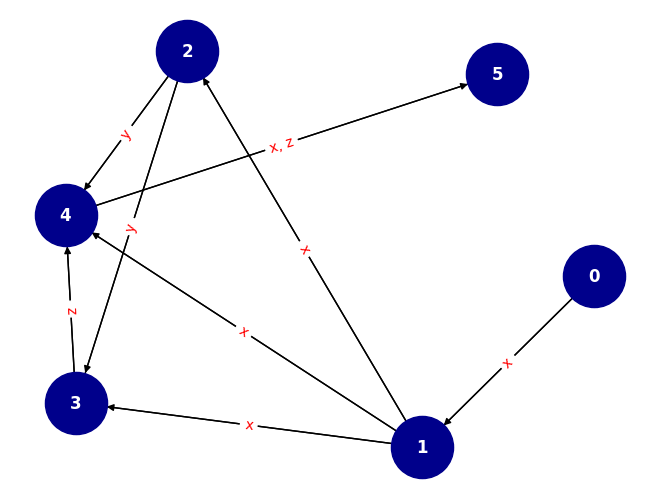

In [786]:
graph.visualize_graph()

In [787]:
graph.visualize_graph_data()

Nodes Table:
╒═════════════╤═════════════════════════╤════════════╤═════════════════╕
│   code_line │ statement               │ has        │ needs           │
╞═════════════╪═════════════════════════╪════════════╪═════════════════╡
│           0 │ def func1(x):           │ ['x']      │ []              │
├─────────────┼─────────────────────────┼────────────┼─────────────────┤
│           1 │ x = x + 2               │ ['x']      │ ['x']           │
├─────────────┼─────────────────────────┼────────────┼─────────────────┤
│           2 │ y = x                   │ ['y']      │ ['x']           │
├─────────────┼─────────────────────────┼────────────┼─────────────────┤
│           3 │ z = x * (x - 2 + 3) * y │ ['z']      │ ['x', 'y']      │
├─────────────┼─────────────────────────┼────────────┼─────────────────┤
│           4 │ if z > x:               │ ['x', 'z'] │ ['x', 'y', 'z'] │
│             │     z = 9               │            │                 │
│             │ elif z < y:           